# vocals-noise.separation
Here is a small research project for cleaned vocals/background noise extraction from a video file.

In [2]:
from src.extract_audio import extract_audio

from src.WER import calculate_wer
from src.SNR import calculate_snr

from src.cocktail import stereo_to_mono
from src.cocktail import center
from src.cocktail import create_dummy_signal
from src.cocktail import whiten
from src.cocktail import ica

import librosa
import soundfile as sf
from scipy.io import wavfile as wf
from transformers import pipeline

import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np

In [1]:
from spleeter.separator import Separator

/Users/tema/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## 0. Data

In [3]:
# Define the paths to the video files
video_files = {
    "simple": "data/raw/video/simple.mov",
    "crowd": "data/raw/video/crowd.mov",
    "music": "data/raw/video/music.mov"
}

# Define the output directory for the extracted audio files
output_dir = "data/raw/audio/"

In [4]:
# Extract audio from each video and store the paths
extracted_audio_paths = {}
for name, path in video_files.items():
    output_path = output_dir + name + ".wav"
    result = extract_audio(path, output_path)
    extracted_audio_paths[name] = result

ffmpeg version 6.0 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 14.0.3 (clang-1403.0.22.14.1)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/6.0_1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --di

## 1. Baseline

### 1.1 The "very" baseline. (low benchmark)

Let's start with implementing simple vocal separation using Nearest Neighbours filtering.

In [18]:
y, sr = librosa.load('data/raw/audio/simple.wav')
ipd.Audio(data=y, rate=sr)

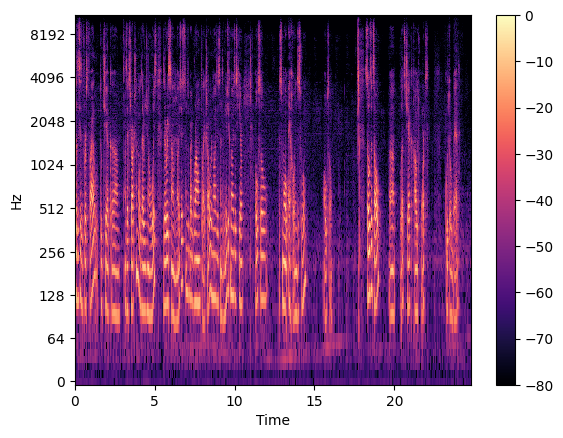

In [19]:
S_full, phase = librosa.magphase(librosa.stft(y))
idx = slice(*librosa.time_to_frames([90*110], sr=sr))
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max), y_axis='log', x_axis='time', sr=sr, ax=ax)
fig.colorbar(img, ax=ax)

In [20]:
S_filter = librosa.decompose.nn_filter(S_full, aggregate=np.median, metric='cosine', width=int(librosa.time_to_frames(2, sr=sr)))
S_filter = np.minimum(S_full, S_filter)

In [21]:
margin_i, margin_v = 3, 11
power = 3

mask_i = librosa.util.softmask(S_filter, margin_i * (S_full - S_filter), power=power)
mask_v = librosa.util.softmask(S_full - S_filter, margin_v * S_filter, power=power)

S_foreground = mask_v * S_full
S_background = mask_i * S_full

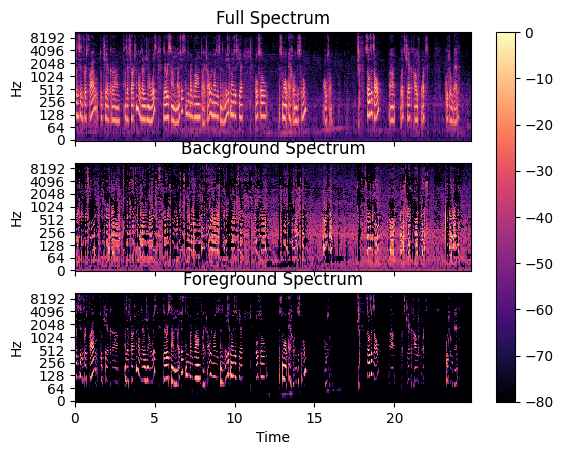

In [22]:
fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)
img = librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max), y_axis='log', x_axis='time', sr=sr, ax=ax[0])
ax[0].set(title='Full Spectrum')
ax[0].label_outer()

librosa.display.specshow(librosa.amplitude_to_db(S_background[:, idx], ref=np.max), y_axis='log', x_axis='time', sr=sr, ax=ax[1])
ax[1].set(title='Background Spectrum')
ax[1].label_outer()

librosa.display.specshow(librosa.amplitude_to_db(S_foreground[:, idx], ref=np.max), y_axis='log', x_axis='time', sr=sr, ax=ax[2])
ax[2].set(title='Foreground Spectrum')
ax[2].label_outer()

fig.colorbar(img, ax=ax)

In [23]:
y_foreground = librosa.istft(S_foreground * phase)
sf.write('data/voices/baseline/simple_voice.wav', y_foreground, sr)
ipd.Audio(data=y_foreground, rate=sr)

In [27]:
print("SNR: ", calculate_snr('data/raw/audio/simple.wav', 'data/voices/baseline/simple_voice.wav'))

SNR:  -5.841022729873657


In [8]:
asr = pipeline("automatic-speech-recognition")
print("\n WER :", calculate_wer(open('data/raw/transcripts/simple.txt', 'r').read().upper(), asr('data/voices/baseline/simple_voice.wav')['text']))

No model was supplied, defaulted to facebook/wav2vec2-base-960h and revision 55bb623 (https://huggingface.co/facebook/wav2vec2-base-960h).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebo

Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize

 WER : 0.6739130434782609


## 2. Advanced models

### 2.1 The "Cocktail Party Algorithm".

Let's start with more advanced Digital Signal Processing techniques.

In [4]:
sampling_rate, x = wf.read('data/raw/audio/crowd.wav')

# Process the audio file
x_mono = stereo_to_mono(x)  # Convert to mono
x_centered = center(x_mono)  # Center the audio
x_dummy = create_dummy_signal(x_centered)  # Create a dummy signal
X_whiten = whiten(x_dummy)

In [5]:
S = ica(X_whiten, iterations=100)

# Write the separated audio to files
wf.write('data/voices/cocktail/crowd_voice.wav', sampling_rate, S[1].astype(np.float32)) 
wf.write('data/background/cocktail/crowd_background.wav', sampling_rate, S[0].astype(np.float32))

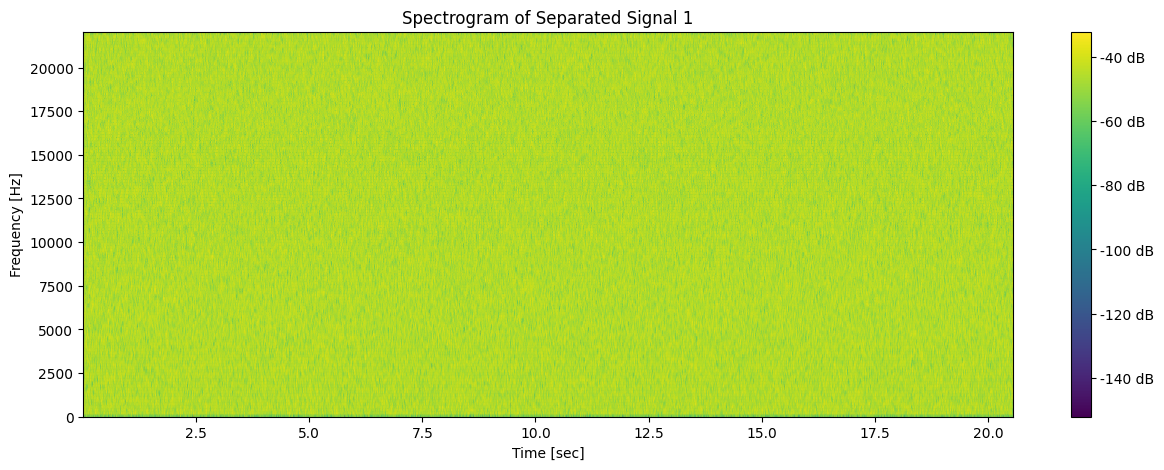

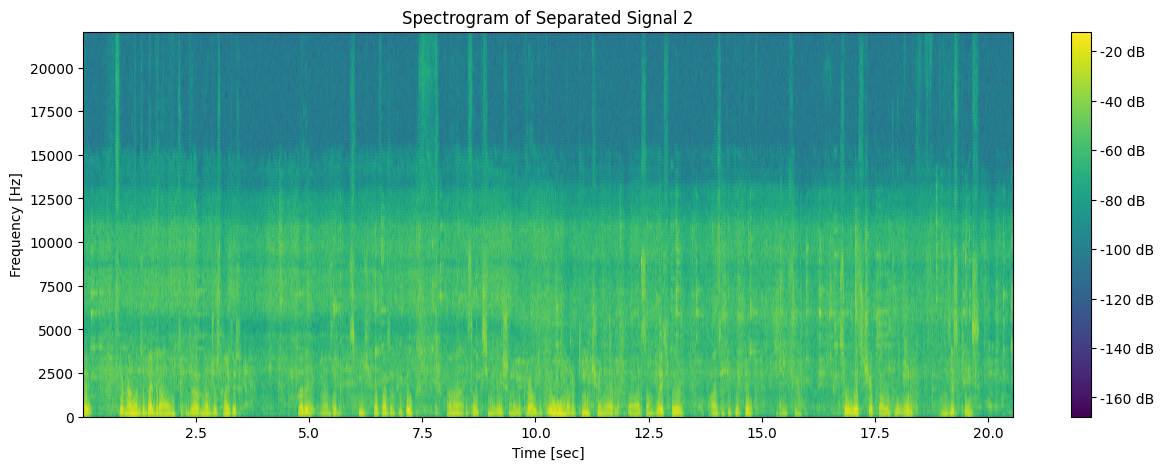

In [16]:
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

# Assuming 'x' is your mono mixed audio signal
fs = sampling_rate  # Sampling frequency

# Calculate the spectrogram of the original mixed signal
frequencies, times, Sxx = spectrogram(x, fs)

# Since the signal is stereo, we take one channel for the spectrogram, e.g., the left channel
Sxx = Sxx[0]

for i, component in enumerate(S):
    frequencies, times, Sxx = spectrogram(component, fs)
    plt.figure(figsize=(15, 5))
    plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title(f'Spectrogram of Separated Signal {i+1}')
    plt.colorbar(format='%+2.0f dB')
    plt.show()


In [6]:
print("SNR: ", calculate_snr('data/raw/audio/crowd.wav', 'data/voices/cocktail/crowd_voice.wav'))

SNR:  0.07617822848260403


In [9]:
print("\n WER :", calculate_wer(open('data/raw/transcripts/crowd.txt', 'r').read().upper(), asr('data/voices/cocktail/crowd_voice.wav')['text']))


 WER : 0.782608695652174


### 2.2 Fine tuning

Let's move to the Deep Learning approach.

In [2]:
# Initialize the separator with 2 stems model
separator = Separator('spleeter:2stems')

# Separate the audio file
separator.separate_to_file('data/raw/audio/crowd.wav', 'data')


INFO:tensorflow:Apply unet for vocals_spectrogram
Instructions for updating:
Colocations handled automatically by placer.
INFO:tensorflow:Apply unet for accompaniment_spectrogram
INFO:spleeter:Downloading model archive https://github.com/deezer/spleeter/releases/download/v1.4.0/2stems.tar.gz
INFO:spleeter:Validating archive checksum
INFO:spleeter:Extracting downloaded 2stems archive
INFO:spleeter:2stems model file(s) extracted
INFO:tensorflow:Restoring parameters from pretrained_models/2stems/model


/Users/tema/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/tema/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


INFO:spleeter:File data/crowd/accompaniment.wav written succesfully
INFO:spleeter:File data/crowd/vocals.wav written succesfully


In [4]:
print("SNR: ", calculate_snr('data/raw/audio/crowd.wav', 'data/voices/spleeter/crowd_voice.wav'))

SNR:  18.35285186767578


In [5]:
print("\n WER :", calculate_wer(open('data/raw/transcripts/crowd.txt', 'r').read().upper(), asr('data/voices/spleeter/crowd_voice.wav')['text']))


 WER : 0.6739130434782609


## 3. Futher research

To create an effective speech-to-text pipeline, integrate audio separation tools like Spleeter, aligning with a larger workflow we need to tune all modules in the solution (separation, speech recognition, language models, ...) to reach the quality tresholds and not be over comlicated and demanding. 